In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU, Concatenate, Flatten
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
#  Data Loading
def load_and_preprocess_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    
    # Separate features and target
    X = df.drop('Label', axis=1).values
    y = df['Label'].values
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
  
    
    # Reshape input for CNN and RNN models (samples, timesteps, features)
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return X_train_reshaped, X_test_reshaped, y_train, y_test


In [3]:
# Build Ensemble Model

def build_ensemble_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    # CNN branch
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    
    # LSTM branch
    lstm = LSTM(64, return_sequences=True)(input_layer)
    lstm = LSTM(32)(lstm)
    
    # BiLSTM branch
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    bilstm = Bidirectional(LSTM(32))(bilstm)
    
    # GRU branch
    gru = GRU(64, return_sequences=True)(input_layer)
    gru = GRU(32)(gru)
    
    # Concatenate all branches
    merged = Concatenate()([cnn, lstm, bilstm, gru])
    
    # Dense layers
    dense = Dense(64, activation='relu')(merged)
    dense = Dense(32, activation='relu')(dense)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [4]:
# Cell 3: Training and Evaluation Function
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    auc = roc_auc_score(y_test, y_pred)
    

     # Print classification report
      # Print classification report
    classification_rep = classification_report(y_test, y_pred_classes)
    print("Classification Report:")
    print(classification_rep)


    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Ensemble Model - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Ensemble Model - Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Ensemble Model - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

     # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'classification_report': classification_rep
    }


(41972, 50, 1)
(10494, 50, 1)
(41972,)
(10494,)
(50, 1)
Training Ensemble Model...

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 24, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 22, 32)    │      6,176 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 11, 32)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50, 64)    │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 128)   │     33,792 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 50, 64)    │     12,864 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 352)       │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 32)        │      9,408 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 480)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0],     │
│                     │                   │            │ bidirectional_1[… │
│                     │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     30,784 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 165,921 (648.13 KB)

 Trainable params: 165,921 (648.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.9852 - loss: 0.0597 - val_accuracy: 0.9982 - val_loss: 0.0043
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9996 - val_loss: 0.0022
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 0.9996 - val_loss: 0.0016
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.0520e-04
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.9997 - loss: 7.8533e-04 - val_accuracy: 0.9999 - val_loss: 6.7095e-04
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9999 - val_loss: 7.6533e-04
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 8.2691e-05
Epoch 8/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step 

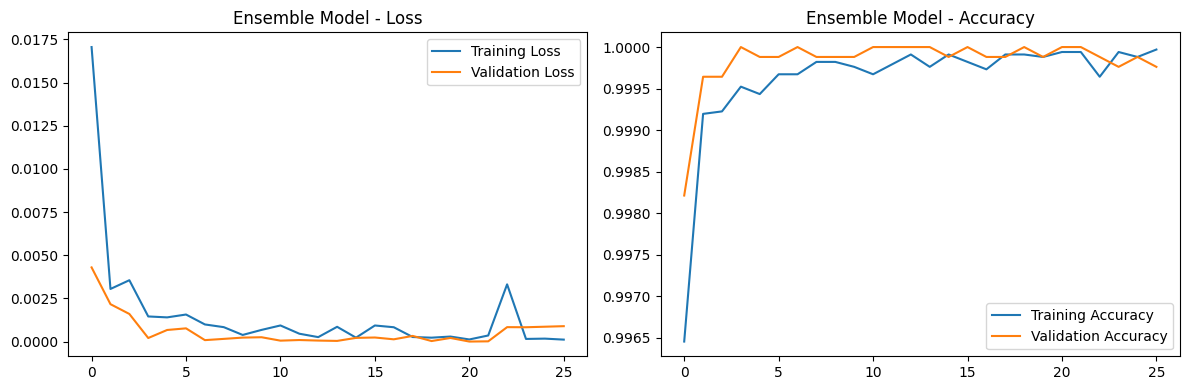

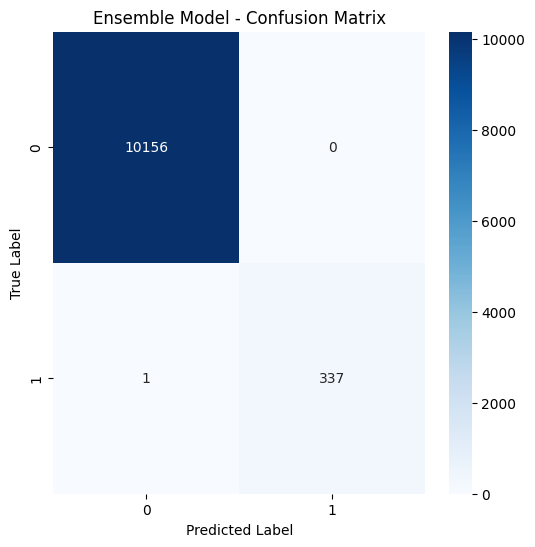

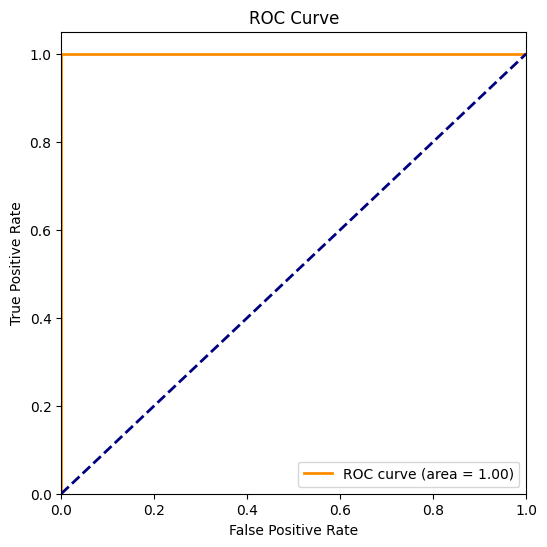


Ensemble Model Results:
accuracy: 0.9999
precision: 1.0000
recall: 0.9970
f1_score: 0.9985
auc: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10156
           1       1.00      1.00      1.00       338

    accuracy                           1.00     10494
   macro avg       1.00      1.00      1.00     10494
weighted avg       1.00      1.00      1.00     10494



In [5]:
# Cell 4: Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    X_train, X_test, y_train, y_test = load_and_preprocess_data('processed_features.csv')

    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    
    # Get input shape
    input_shape = (X_train.shape[1], 1)

    print(input_shape)
    
    # Build and train ensemble model
    print("Training Ensemble Model...")
    ensemble_model = build_ensemble_model(input_shape)
    print("\nModel Architecture:")
    ensemble_model.summary()
    
    # Train and evaluate the model
    results = train_and_evaluate_model(ensemble_model, X_train, X_test, y_train, y_test)
    
    # Print results
print("\nEnsemble Model Results:")
for metric, value in results.items():
    if metric == 'classification_report':
        print(f"\nClassification Report:\n{value}")
    elif isinstance(value, (int, float)):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

# Save comprehensive results to text file
with open('ensemble_model_results_.txt', 'w') as f:
    # Write timestamp
    from datetime import datetime
    f.write(f"Model Evaluation Results - Ensemble Model\n")
    f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*50 + "\n\n")
    
    # Write detailed results
    f.write("Detailed Results:\n")
    f.write("-"*20 + "\n")
    for metric, value in results.items():
        if metric == 'classification_report':
            f.write(f"\nClassification Report:\n{value}\n")
        elif isinstance(value, (int, float)):
            f.write(f"{metric:<15}: {value:.4f}\n")
        else:
            f.write(f"{metric:<15}: {value}\n")
    f.write("\n")